In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import io
import seaborn as sns
import os
import sys

In [16]:
def preprocess_data(file_path):
    """
    Reads the data from a CSV file and adds necessary columns for visualization.
    """
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file '{file_path}' was not found.")
        
    df = pd.read_csv(file_path)
    
    # Calculate 95% Confidence Interval
    # Formula: CI = 1.96 * (std / sqrt(N))
    # We do this for both Chamfer and Swiss metrics
    df['chamfer_ci'] = 1.96 * (df['chamfer_std'] / np.sqrt(df['num_eval_samples']))
    df['swiss_ci'] = 1.96 * (df['swiss_dist_std'] / np.sqrt(df['num_eval_samples']))
    
    # Create a clean label for the X-axis based on Tangent/Normal Ratio
    def get_label_and_sort(row):
        t = row['tangent_fraction']
        n = row['normal_fraction']
        
        if n == 0:
            # Denominator is 0, purely tangent noise
            return f"Tangent Only (T={t})", float('inf')
        else:
            # Ratio T/N
            ratio = t / n
            return f"{ratio:.2f}", ratio

    # Apply function with result_type='expand' to ensure we get a DataFrame with columns 0, 1
    label_sort_df = df.apply(lambda row: get_label_and_sort(row), axis=1, result_type='expand')
    
    # Assign columns individually to be safe (Fixes KeyError issue)
    df['Config_Label'] = label_sort_df[0]
    df['Sort_Key'] = label_sort_df[1]
    
    return df

In [17]:
def plot_bar_charts_by_epoch(df, metric_mean, metric_ci, title_prefix):
    """
    Creates a grid of bar charts, one per Epoch value.
    Ensures consistent X-axis ordering across epochs for comparison.
    """
    unique_epochs = sorted(df['num_epochs'].unique())
    n_epochs = len(unique_epochs)
    
    # Define a consistent order for the configurations based on the Sort_Key (Ratio)
    # This sorts from Normal-dominated (Ratio 0) to Tangent-dominated (Ratio Inf)
    config_order = df.sort_values('Sort_Key')['Config_Label'].unique()
    
    fig, axes = plt.subplots(1, n_epochs, figsize=(6 * n_epochs, 6), sharey=True)
    if n_epochs == 1: axes = [axes] # Handle single plot case
    
    # Determine log scale requirement based on global data range
    use_log = (df[metric_mean].max() / df[metric_mean].min()) > 100
    
    for ax, epoch in zip(axes, unique_epochs):
        # Filter for the current epoch
        subset = df[df['num_epochs'] == epoch]
        
        # We must index the subset by our fixed order to ensure error bars 
        # and labels match the seaborn barplot order
        # Note: We need to handle cases where a config might be missing in a specific epoch
        # reindex will introduce NaNs for missing configs, which barplot handles (empty space)
        subset = subset.set_index('Config_Label').reindex(config_order).reset_index()
        
        sns.barplot(
            data=subset, x='Config_Label', y=metric_mean,
            ax=ax, palette='viridis', edgecolor='black', order=config_order
        )
        
        # Add error bars manually
        # Since we forced the order in 'subset', these line up with the bars
        x_coords = range(len(subset))
        
        # Only plot error bars where data exists
        valid_indices = subset[metric_mean].notna()
        if valid_indices.any():
            ax.errorbar(
                [x for x, valid in zip(x_coords, valid_indices) if valid],
                subset.loc[valid_indices, metric_mean],
                yerr=subset.loc[valid_indices, metric_ci],
                fmt='none', c='black', capsize=5
            )

        ax.set_title(f"Epochs: {epoch}")
        ax.set_xlabel("Noise Config (Tangent/Normal Ratio)")
        
        if use_log: 
            ax.set_yscale('log')
            
        ax.tick_params(axis='x', rotation=45)
        
        # Labels on top
        for i, v in enumerate(subset[metric_mean]):
            if pd.notna(v): # Check for NaN in case of missing data for a config
                ax.text(i, v, f"{v:.1f}", ha='center', va='bottom', fontsize=8, fontweight='bold')

    axes[0].set_ylabel(f"{title_prefix} (Lower is Better)")
    plt.suptitle(f"{title_prefix} by Epoch", fontsize=16)
    plt.tight_layout()
    plt.show()

Generating Visualizations...


/var/folders/rr/cq_rkbv541d24_j5xzk1s3sc0000gn/T/ipykernel_61883/3595146358.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/rr/cq_rkbv541d24_j5xzk1s3sc0000gn/T/ipykernel_61883/3595146358.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/rr/cq_rkbv541d24_j5xzk1s3sc0000gn/T/ipykernel_61883/3595146358.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


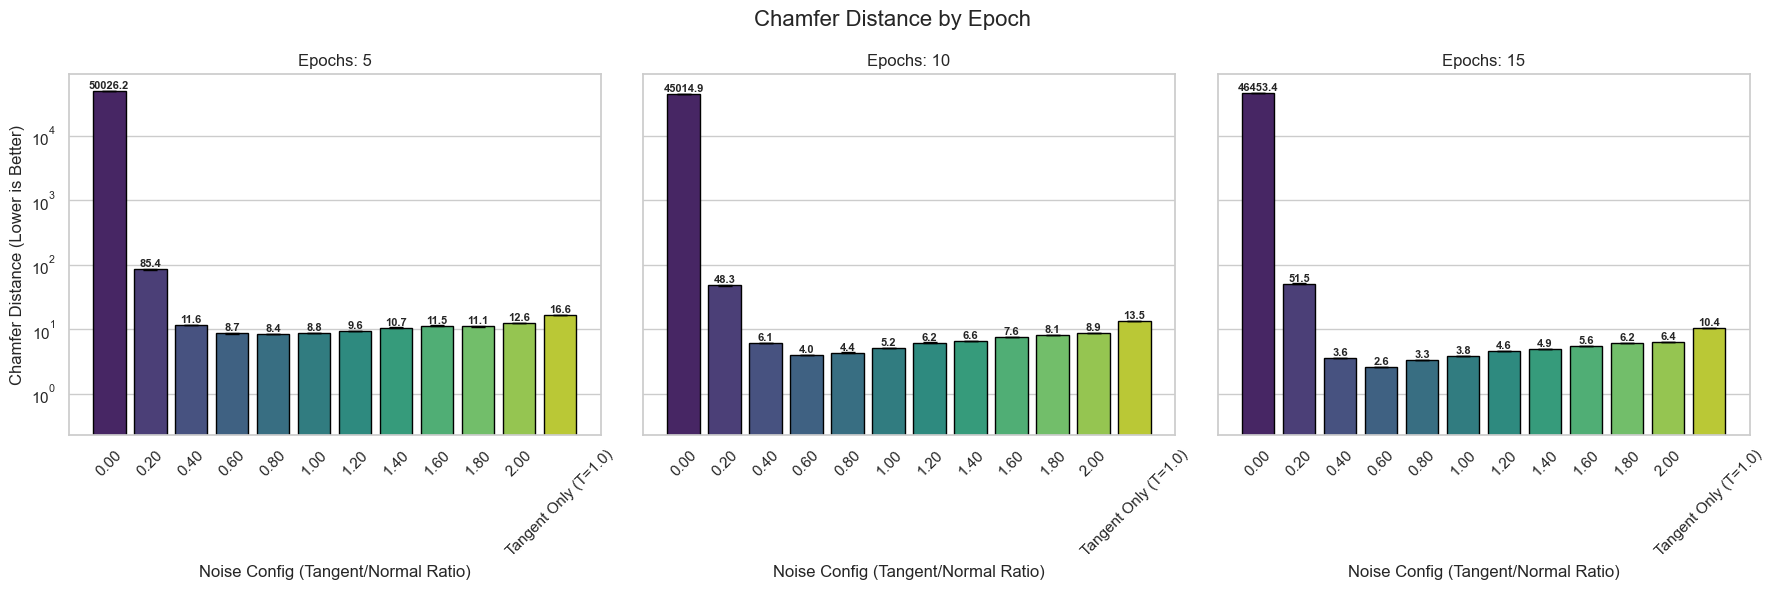

In [18]:
sns.set_theme(style="whitegrid")
    
df = preprocess_data('outputs/full_swissroll_experiments/summary.csv')

print("Generating Visualizations...")

# 1. Chamfer Distance Visuals
plot_bar_charts_by_epoch(df, 'chamfer_mean', 'chamfer_ci', 'Chamfer Distance')

In [19]:
df

,name,use_manifold,mixed_noise,tangent_fraction,normal_fraction,num_timesteps,num_epochs,batch_size,lr,num_eval_samples,...,seed,device,chamfer_mean,swiss_dist_mean,chamfer_std,swiss_dist_std,chamfer_ci,swiss_ci,Config_Label,Sort_Key
0,embed_dim_3_baseline_full_normal_epochs5,True,True,0.0,1.0,1000,5,128,0.001,2000,...,0,NaN,50026.160937,49995.720703,4914.178307,4913.970789,215.373360,215.364265,0.00,0.0
1,embed_dim_3_baseline_full_tangent_epochs5,True,True,1.0,0.0,1000,5,128,0.001,2000,...,0,NaN,16.620647,15.264181,1.928637,1.948737,0.084526,0.085407,Tangent Only (T=1.0),inf
2,embed_dim_3_tangent_ratio_0.20_epochs5,True,True,1.0,5.0,1000,5,128,0.001,2000,...,0,NaN,85.408467,82.317927,35.725858,35.333589,1.565755,1.548563,0.20,0.2
3,embed_dim_3_tangent_ratio_0.40_epochs5,True,True,2.0,5.0,1000,5,128,0.001,2000,...,0,NaN,11.578060,9.920459,1.369466,1.277491,0.060020,0.055989,0.40,0.4
4,embed_dim_3_tangent_ratio_0.60_epochs5,True,True,3.0,5.0,1000,5,128,0.001,2000,...,0,NaN,8.651838,7.334210,0.740852,0.672057,0.032469,0.029454,0.60,0.6
5,embed_dim_3_tangent_ratio_0.80_epochs5,True,True,4.0,5.0,1000,5,128,0.001,2000,...,0,NaN,8.435466,7.145408,0.773496,0.748887,0.033900,0.032821,0.80,0.8
6,embed_dim_3_tangent_ratio_1.00_epochs5,True,True,5.0,5.0,1000,5,128,0.001,2000,...,0,NaN,8.774717,7.499936,1.061272,1.034322,0.046512,0.045331,1.00,1.0
7,embed_dim_3_tangent_ratio_1.20_epochs5,True,True,6.0,5.0,1000,5,128,0.001,2000,...,0,NaN,9.556081,8.279276,1.167312,1.092863,0.051160,0.047897,1.20,1.2
8,embed_dim_3_tangent_ratio_1.40_epochs5,True,True,7.0,5.0,1000,5,128,0.001,2000,...,0,NaN,10.690031,9.415418,1.032586,1.026630,0.045255,0.044994,1.40,1.4
9,embed_dim_3_tangent_ratio_1.60_epochs5,True,True,8.0,5.0,1000,5,128,0.001,2000,...,0,NaN,11.481174,10.157560,1.230806,1.199904,0.053942,0.052588,1.60,1.6


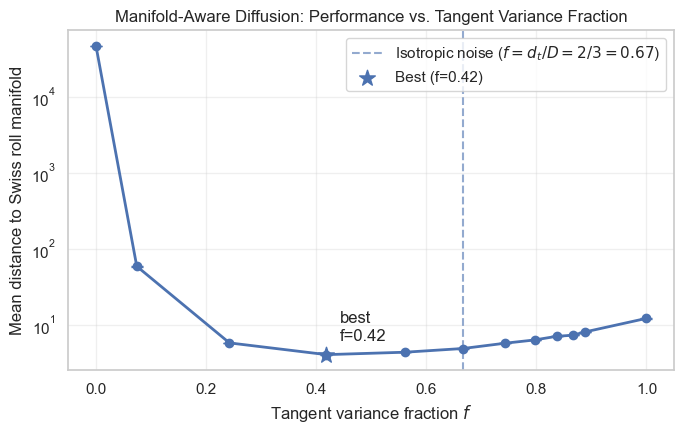

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def infer_D_from_name(name: str) -> int | None:
    if "embed_dim_" not in name:
        return None
    try:
        return int(name.split("embed_dim_")[1].split("_")[0])
    except Exception:
        return None

def add_tangent_variance_fraction(df, intrinsic_dim=2):
    """
    Adds tangent variance fraction f:
      f = (d_t * a^2) / (d_t * a^2 + d_n * b^2)

    Note: a,b here are the *effective* (post-normalization) multipliers used in noiser().
    In your code, self.tangent_fraction and self.normal_fraction are scaled so E||eps||^2 ≈ D,
    but f is invariant to that common scaling anyway.
    """
    df = df.copy()

    def compute_f(row):
        a = float(row["tangent_fraction"])
        b = float(row["normal_fraction"])
        D = infer_D_from_name(str(row["name"]))
        if D is None:
            return np.nan
        d_t = intrinsic_dim
        d_n = D - d_t
        denom = d_t * a**2 + d_n * b**2
        if denom <= 0:
            return np.nan
        return (d_t * a**2) / denom

    df["D"] = df["name"].astype(str).apply(infer_D_from_name)
    df["f"] = df.apply(compute_f, axis=1)
    return df

def aggregate_by_f(df, metric="swiss_dist_mean", ci_col="swiss_ci"):
    agg = (
        df.dropna(subset=["f"])
          .groupby("f", as_index=False)
          .agg(
              mean_metric=(metric, "mean"),
              mean_ci=(ci_col, "mean"),
          )
          .sort_values("f")
    )
    return agg

def plot_metric_vs_f_with_best(
    df_with_f,
    metric="swiss_dist_mean",
    ci_col="swiss_ci",
    intrinsic_dim=2,
    title="Manifold-Aware Diffusion: Performance vs. Tangent Variance Fraction",
    ylabel="Mean distance to Swiss roll manifold",
):
    # Aggregate
    agg = aggregate_by_f(df_with_f, metric=metric, ci_col=ci_col)

    # Infer D (assumes constant D in this subset)
    Ds = df_with_f["D"].dropna().unique()
    if len(Ds) != 1:
        raise ValueError(f"Expected a single ambient dimension D, found: {Ds}")
    D = int(Ds[0])
    f_iso = intrinsic_dim / D

    # Best point (min metric)
    best_idx = agg["mean_metric"].idxmin()
    best_f = float(agg.loc[best_idx, "f"])
    best_y = float(agg.loc[best_idx, "mean_metric"])

    plt.figure(figsize=(7, 4.5))

    # main curve + CI
    plt.errorbar(
        agg["f"], agg["mean_metric"], yerr=agg["mean_ci"],
        fmt="-o", capsize=4, linewidth=2, markersize=6,
    )

    # isotropic reference
    plt.axvline(
        x=f_iso, linestyle="--", alpha=0.6,
        label=rf"Isotropic noise ($f=d_t/D={intrinsic_dim}/{D}={f_iso:.2f}$)"
    )

    # highlight best
    plt.scatter([best_f], [best_y], s=140, marker="*", zorder=5, label=f"Best (f={best_f:.2f})")
    plt.annotate(
        f"best\nf={best_f:.2f}",
        xy=(best_f, best_y),
        xytext=(10, 10),
        textcoords="offset points",
    )

    plt.yscale("log")
    plt.xlabel(r"Tangent variance fraction $f$")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Usage:
df_dim3 = df[df["name"].astype(str).str.contains("embed_dim_3")]
df_dim3 = add_tangent_variance_fraction(df_dim3, intrinsic_dim=2)
plot_metric_vs_f_with_best(df_dim3, metric="swiss_dist_mean", ci_col="swiss_ci", intrinsic_dim=2)


In [10]:
def plot_convergence_lines(df, metric_mean, title_prefix):
    """
    Plots the metric over epochs to show convergence speed.
    """
    plt.figure(figsize=(10, 6))
    
    # Filter out the outlier to prevent graph collapse
    df = df[~df['Config_Label'].isin(["0.00", "0.20"])].copy()
    
    if df.empty:
        print("Warning: All data was filtered out in plot_convergence_lines.")
        return

    use_log = (df[metric_mean].max() / df[metric_mean].min()) > 100
    
    # Sort legend by ratio
    df = df.sort_values('Sort_Key')
    
    sns.lineplot(
        data=df, 
        x='num_epochs', 
        y=metric_mean, 
        hue='Config_Label',
        style='Config_Label',
        markers=True, 
        dashes=False,
        linewidth=2.5,
        palette='tab10',
        hue_order=df['Config_Label'].unique(),
        style_order=df['Config_Label'].unique()
    )
    
    if use_log: plt.yscale('log')
    plt.title(f"{title_prefix}: Convergence over Epochs (Excluding 0.00)")
    plt.ylabel(f"{title_prefix} (Mean)")
    plt.xlabel("Training Epochs")
    plt.grid(True, which="both", linestyle='--', alpha=0.5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Ratio (T/N)")
    plt.tight_layout()
    plt.show()

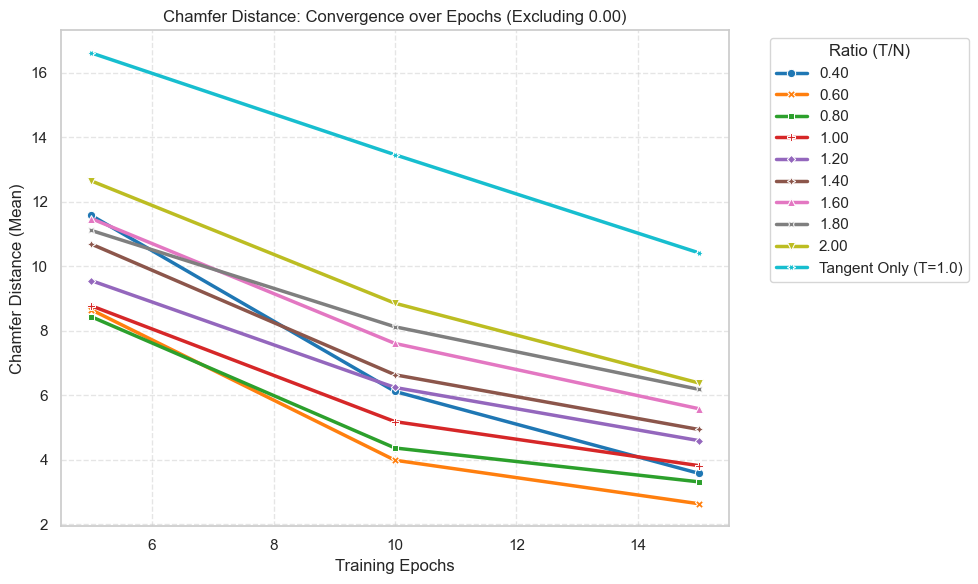

In [11]:
plot_convergence_lines(df, 'chamfer_mean', 'Chamfer Distance')

In [12]:
def plot_heatmaps(df, metric_mean, title_prefix):
    """
    Creates heatmaps of Tangent vs Normal fraction for the metric.
    One heatmap per Epoch setting (since values change over time).
    """

    unique_epochs = sorted(df['num_epochs'].unique())
    
    fig, axes = plt.subplots(1, len(unique_epochs), figsize=(5 * len(unique_epochs), 5))
    if len(unique_epochs) == 1: axes = [axes]
    
    for ax, epoch in zip(axes, unique_epochs):
        subset = df[df['num_epochs'] == epoch]
        
        # Pivot table: Rows=Tangent, Cols=Normal, Values=Metric
        pivot_table = subset.pivot_table(
            index='tangent_fraction', 
            columns='normal_fraction', 
            values=metric_mean
        )
        
        sns.heatmap(
            pivot_table, 
            annot=True, 
            fmt=".1f", 
            cmap="RdYlGn_r", # Red = High (Bad), Green = Low (Good)
            ax=ax,
            cbar_kws={'label': title_prefix}
        )
        ax.set_title(f"Epochs: {epoch}")
        ax.invert_yaxis() # Standard plot orientation
        
    plt.suptitle(f"{title_prefix} Heatmap (Tangent vs Normal)", fontsize=16)
    plt.tight_layout()
    plt.show()

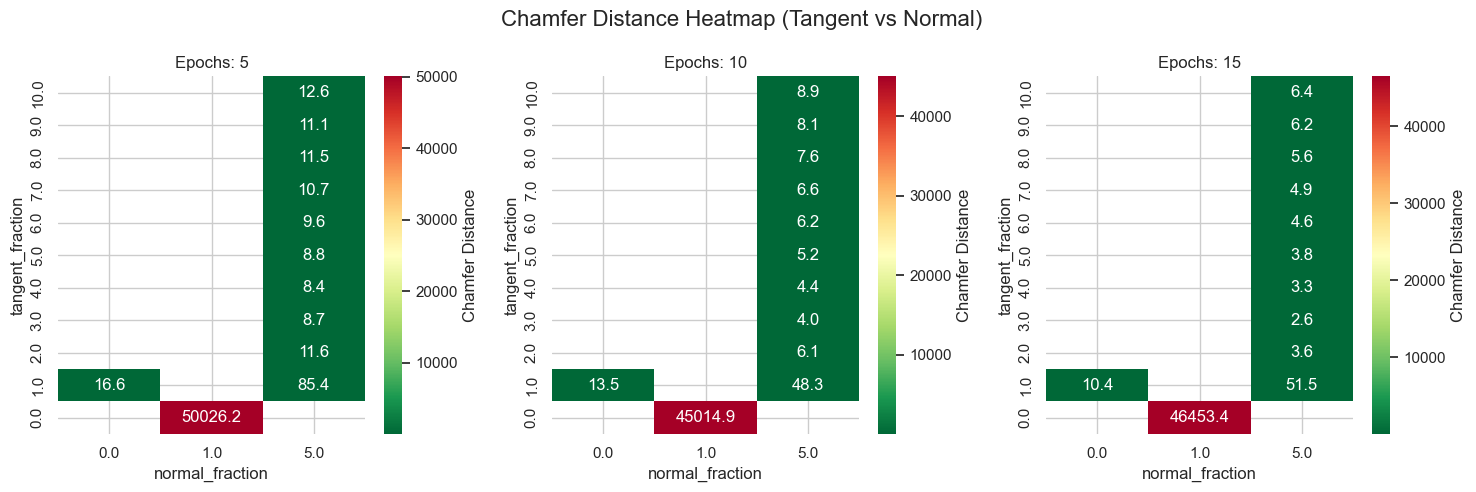

In [13]:
try:
    plot_heatmaps(df, 'chamfer_mean', 'Chamfer Distance')
except Exception as e:
    print(f"Skipping Heatmap: Data might not be dense enough grid. {e}")

Generating Swiss Distance Visuals...


/var/folders/rr/cq_rkbv541d24_j5xzk1s3sc0000gn/T/ipykernel_61883/3595146358.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/rr/cq_rkbv541d24_j5xzk1s3sc0000gn/T/ipykernel_61883/3595146358.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/rr/cq_rkbv541d24_j5xzk1s3sc0000gn/T/ipykernel_61883/3595146358.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


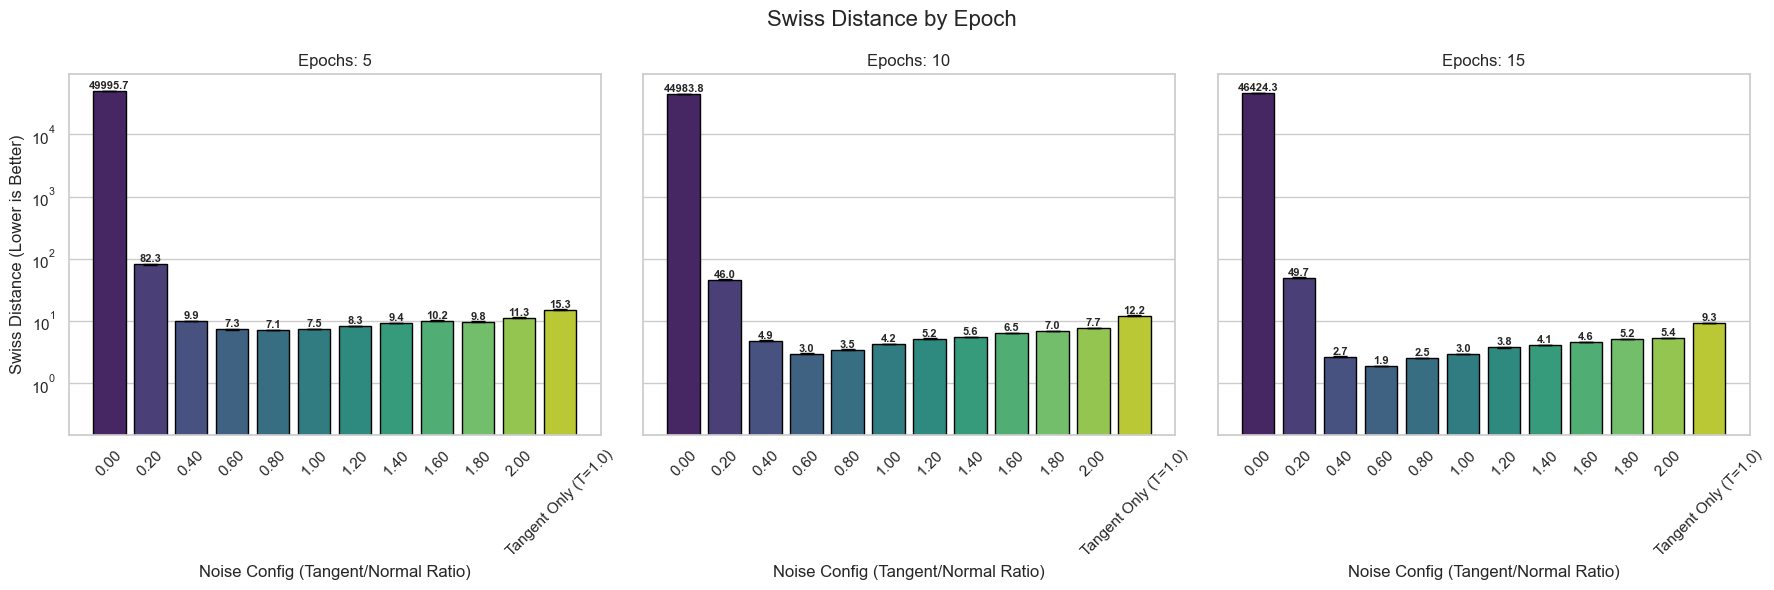

In [14]:
# 2. Swiss Distance Visuals
print("Generating Swiss Distance Visuals...")
plot_bar_charts_by_epoch(df, 'swiss_dist_mean', 'swiss_ci', 'Swiss Distance')


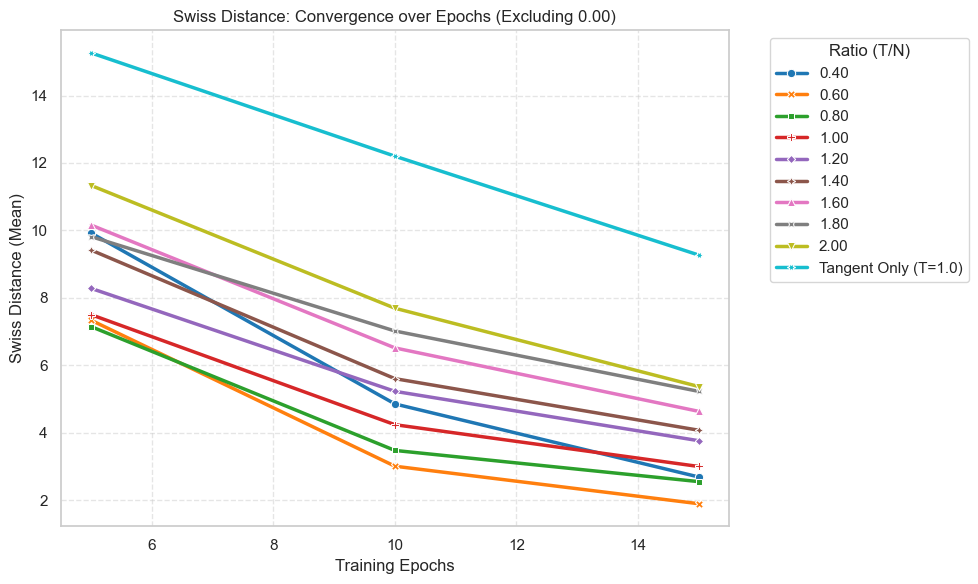

In [11]:
plot_convergence_lines(df, 'swiss_dist_mean', 'Swiss Distance')